# ANNA-T - Automated Non-Neural Audio Transcription
* by Keshav Nath

Note: All the drive directories and all are called "oh-sheet" because that was my original project name

## Environment Setup

In [ ]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.fftpack import fft

from intervaltree import Interval,IntervalTree

from time import time

import tensorflow as tf

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

%matplotlib inline

In [ ]:
data_dir = "drive/MyDrive/oh-sheet/Custom/"

##Getting data from directory

In [ ]:
import os

all_audios = os.listdir(data_dir)
midi_paths=[]
audio_paths=[]

for path in all_audios:
  if path[-3:]=="mp3":
    audio_paths.append(data_dir+path)
  elif path[-3:]=="mid":
    midi_paths.append(data_dir+path)

print(midi_paths)
print(audio_paths)

['drive/MyDrive/oh-sheet/Custom/Alan Walker - Faded Piano.mid', 'drive/MyDrive/oh-sheet/Custom/The Chainsmokers ft. Halsey - Closer.mid', 'drive/MyDrive/oh-sheet/Custom/C418 - Sweden (Minecraft Main Theme).mid', 'drive/MyDrive/oh-sheet/Custom/Lewis Capaldi - Before You Go.mid', 'drive/MyDrive/oh-sheet/Custom/Martin Garrix & Bebe Rexha - In The Name Of Love.mid', 'drive/MyDrive/oh-sheet/Custom/The Weeknd ft. Daft Punk - I Feel It Coming.mid', 'drive/MyDrive/oh-sheet/Custom/Billie Eilish - Bad Guy.mid', 'drive/MyDrive/oh-sheet/Custom/Luis Fonsi ft. Daddy Yankee - Despacito.mid', 'drive/MyDrive/oh-sheet/Custom/The Chainsmokers - Paris.mid', 'drive/MyDrive/oh-sheet/Custom/Avicii - Without You.mid', 'drive/MyDrive/oh-sheet/Custom/Shawn Mendes - Theres Nothing Holdin Me Back.mid', 'drive/MyDrive/oh-sheet/Custom/Ed Sheeran - Shape of You.mid', 'drive/MyDrive/oh-sheet/Custom/Tones And I - Dance Monkey.mid', 'drive/MyDrive/oh-sheet/Custom/San Holo - Light.mid', 'drive/MyDrive/oh-sheet/Custom/Th

##Audio Processing in Librosa

Generating librosa object and resampling to 16000 kHz so song is divided into 32 ms periods
We have used the first song in our directory, just as a sample

In [ ]:
sample_path = audio_paths[0]
y, sr = librosa.load(sample_path, sr=16000)
# y = librosa.resample(y, sr, 16000)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Generating Constant Q-Transform Spectrum

/usr/local/lib/python3.7/dist-packages/librosa/display.py:1336: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  "Frequency axis exceeds Nyquist. "


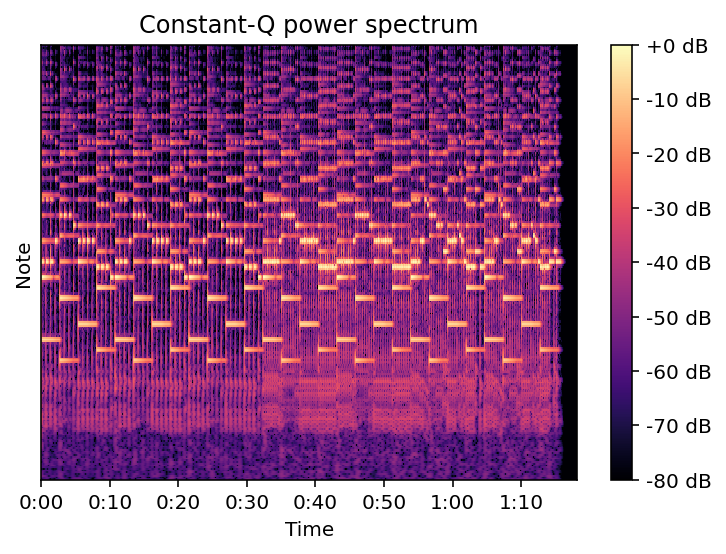

In [ ]:
import librosa.display
C = np.abs(librosa.cqt(y=y, sr=sr, bins_per_octave=36,n_bins=252,hop_length=512))
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                               sr=sr, x_axis='time', y_axis='cqt_note', ax=ax)
ax.set_title('Constant-Q power spectrum')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

In [ ]:
C

array([[7.3304918e-04, 7.6509622e-04, 8.4364554e-04, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [3.2131092e-03, 3.1949803e-03, 3.1457397e-03, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [5.6077731e-03, 5.6012990e-03, 5.5841058e-03, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [8.9883752e-06, 2.0764188e-03, 2.8456158e-03, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.5892159e-05, 1.2905995e-03, 1.5614633e-03, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.6029040e-05, 5.5783368e-03, 2.2412108e-03, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [ ]:
C.shape

(252, 2443)

In [ ]:
import pandas as pd

Making DataFrame from CQT

In [ ]:
C_df = pd.DataFrame(C).T
C_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251
0,0.000733,0.003213,0.005608,0.005022,0.003947,0.002346,0.000042,0.002368,0.003244,0.002150,0.000124,0.001001,0.003671,0.003232,0.002356,0.002011,0.000302,0.004827,0.009599,0.013169,0.014113,0.010955,0.005697,0.004776,0.010485,0.017634,0.019409,0.021221,0.026226,0.017184,0.008076,0.001676,0.034450,0.063667,0.083650,0.093462,0.086033,0.079044,0.054866,0.009191,...,0.000237,0.000194,0.000170,0.000235,0.000038,0.000046,0.000091,0.000009,0.000093,0.000130,0.000088,0.000122,0.000033,0.000170,0.000103,0.000044,0.000060,0.000081,0.000043,0.000071,0.000020,0.000011,0.000006,0.000031,0.000043,0.000040,0.000038,0.000020,0.000014,0.000014,0.000008,0.000011,0.000019,0.000005,0.000021,0.000013,0.000010,0.000009,0.000026,0.000016
1,0.000765,0.003195,0.005601,0.004983,0.003936,0.002343,0.000182,0.002369,0.003223,0.002157,0.000186,0.001036,0.003663,0.003213,0.002329,0.002018,0.000469,0.004800,0.009526,0.013056,0.013985,0.010855,0.005652,0.004721,0.010404,0.017456,0.019253,0.020839,0.026038,0.017146,0.007801,0.002861,0.034499,0.062758,0.082120,0.092126,0.084355,0.077807,0.054478,0.011006,...,0.013417,0.006212,0.034593,0.055422,0.022250,0.004562,0.013863,0.038931,0.029089,0.014453,0.050238,0.051924,0.014707,0.012443,0.015225,0.040680,0.076401,0.035237,0.003892,0.002869,0.012911,0.012092,0.025487,0.069640,0.046353,0.005525,0.006561,0.007395,0.013010,0.038995,0.034444,0.008285,0.001989,0.005093,0.009542,0.011784,0.007901,0.002076,0.001291,0.005578
2,0.000844,0.003146,0.005584,0.004881,0.003906,0.002331,0.000332,0.002369,0.003163,0.002168,0.000313,0.001131,0.003638,0.003164,0.002251,0.002038,0.000753,0.004724,0.009321,0.012735,0.013629,0.010602,0.005519,0.004556,0.010176,0.016957,0.018795,0.019789,0.025513,0.017023,0.007059,0.004877,0.034568,0.060270,0.078009,0.088513,0.079635,0.074281,0.053373,0.014517,...,0.006306,0.004219,0.017567,0.038536,0.018555,0.003979,0.006307,0.051724,0.061725,0.032279,0.046171,0.049624,0.012122,0.004566,0.018912,0.037652,0.048050,0.022384,0.002006,0.003195,0.009493,0.009733,0.028608,0.070725,0.043195,0.002774,0.004165,0.005318,0.007339,0.035932,0.033818,0.008658,0.004180,0.003721,0.011834,0.015175,0.007977,0.002846,0.001561,0.002241
3,0.000948,0.003069,0.005557,0.004721,0.003855,0.002312,0.000460,0.002371,0.003069,0.002182,0.000476,0.001266,0.003580,0.003102,0.002116,0.002073,0.001030,0.004611,0.008994,0.012228,0.013059,0.010199,0.005318,0.004288,0.009811,0.016165,0.018040,0.018109,0.024666,0.016806,0.005914,0.007123,0.034505,0.056315,0.071666,0.082872,0.072202,0.068605,0.051591,0.017787,...,0.005400,0.002562,0.020169,0.040539,0.019949,0.003366,0.008400,0.051928,0.055892,0.018582,0.033563,0.034854,0.007755,0.005860,0.012694,0.028935,0.040318,0.020249,0.002837,0.002804,0.008153,0.006808,0.020311,0.043959,0.028853,0.005567,0.003608,0.004001,0.004517,0.028825,0.027721,0.002541,0.004542,0.005686,0.010837,0.013257,0.008000,0.001033,0.002609,0.003258
4,0.001068,0.002968,0.005516,0.004503,0.003784,0.002288,0.000556,0.002374,0.002946,0.002186,0.000676,0.001448,0.003483,0.003035,0.001919,0.002117,0.001268,0.004473,0.008553,0.011548,0.012286,0.009686,0.005044,0.003910,0.009321,0.015115,0.016999,0.015871,0.023529,0.016519,0.004492,0.009448,0.034139,0.051092,0.063574,0.075535,0.062561,0.061065,0.049182,0.020139,...,0.008402,0.001796,0.021193,0.040875,0.020095,0.001324,0.008830,0.049767,0.059152,0.008974,0.031326,0.030113,0.009093,0.004477,0.012451,0.019467,0.032023,0.013191,0.001021,0.000801,0.006416,0.007632,0.009703,0.024193,0.015684,0.003362,0.002296,0.001647,0.008062,0.029498,0.026309,0.006311,0.002738,0.003302,0.009276,0.012064,0.005832,0.001314,0.001081,0.003517


In [ ]:
C_df.shape

(2443, 252)

Fixing 20 minute length for song

In [ ]:
def fix_song_length(C_df):
  if C_df.shape[0]>37500:
    C_df=C_df[:37500]
  else:
    remain = 37500-C_df.shape[0]
    zeros=pd.DataFrame(np.zeros(shape=(remain,252)))
    C_df = pd.concat([C_df,zeros], ignore_index=True)

def fix_label_length(C_df):
  if C_df.shape[0]>37500:
    C_df=C_df[:37500]
  else:
    remain = 37500-C_df.shape[0]
    zeros=pd.DataFrame(np.zeros(shape=(remain,88)))
    C_df = pd.concat([C_df,zeros], ignore_index=True)
  
  return C_df

In [ ]:
# C_fix=fix_length(C_df)

In [ ]:
# C_fix.shape

In [ ]:
# C_fix[-2:]

##MIDI <--> DataFrame functionality

CSV to Midi from Github

In [ ]:
"""
This is the csv to midi function. 
"""

import re
import os
import random
import sys
import argparse
from fractions import Fraction
 
import music21
# defines numerical values for notes
notes = ['C', 'D-', 'D', 'E-', 'E', 'F', 'G-', 'G', 'A-', 'A', 'B-', 'B']
note_to_num = dict([[n, i] for i, n in enumerate(notes)])
num_to_note = dict([[v, k] for k, v in note_to_num.items()])

same_note = {'A#': 'B-', 'C#': 'D-', 'D#': 'E-', 'F#': 'G-', 'G#': 'A-'}


def split_note(note):
	note=str(note)
	"""Return tuple of strings representing the tone and its octave. 
	>>> split_note("A-7") 
	"A-", "7"
	"""
	assert re.fullmatch('[A-G](#|-)?[0-7]', note) is not None, 'Note not formatted correctly.'
	return note[:-1], int(note[-1])


def name_to_num(name):
	"""Return integer representing "note number", given string name (tone and octave combined). 
	
	>>> name_to_num("A-7")
	104
	"""
	
	note, octave = split_note(name)
	b = ""
	if note in same_note:
		b = note_to_num[same_note[note]]
	else:
		b = note_to_num[note]
	a = (octave + 1) * 12
	return a + b


def produce_midi(df, desired_tempo):
	s1 = music21.stream.Stream()
	mm1 = music21.tempo.MetronomeMark(number=desired_tempo)
	s1.append(mm1)

	running_offset = 0 # essentially, the current total duration we are at while processing the midi file
	for index, row in df.iterrows():
		curr_duration = row[3-1]
		#This rounds durations to real music note types, will include as optional flag sometime in the future
		# if curr_duration < 0.07 and curr_duration > 0.0:
			# note_type = '16th'
		# elif curr_duration < 0.15:
			# note_type = 'eighth'
		# elif curr_duration < 0.30:
			# note_type = 'quarter'
		# elif curr_duration < 0.4: 
			# print("triplet")
		# elif curr_duration < 0.6:
			# note_type = 'half'
		# else: 
			# note_type = "whole" 

		x = music21.note.Note(name_to_num(row[1-1]), duration=music21.duration.Duration(Fraction(curr_duration)))
		#print(x.note_type)
		x.volume.velocity = row[4-1] 
		# x.offset = row[2] * 4 + running_offset # this is measures
		x.offset = row[2-1] + running_offset # this is quarter notes, so all time measurement is consistent
		
		s1.insert(x)
		
		# This code generates random chords for some of the notes, just ignore it
		# interval_range = random.choice([0, 0, 7, 9])
		# i = interval.Interval(interval_range)
		# y = i.transposeNote(x)
		# y.offset = x.offset
		# s1.insert(y)

	# Removes note if too short
	# for note in s1:
		# if note.duration.quarterLength < 0.01:
			# s1.remove(note)

	return s1

Midi to CSV from Github

In [ ]:
"""
This is the midi to csv function
"""

def midi_to_csv(midi_path):
  mf = music21.midi.MidiFile()
  mf.open(midi_path)
  mf.read()
  mf.close()
  s = music21.midi.translate.midiFileToStream(mf, quantizePost=False).flat
  # Quantize is what rounds all note durations to real music note types, not needed for our application
  # Convert chords in to notes.
  df = pd.DataFrame(columns=["note_name", "start_time", "duration", "velocity", "tempo"])
  for g in s.recurse().notes:
    #print(g)
    if g.isChord:
			#print("chord")
			#print(g.pitches)
      for pitch in g.pitches: 
        x = music21.note.Note(pitch, duration=g.duration)
        x.volume.velocity = g.volume.velocity

        x.offset = g.offset
        #print(x)
        s.insert(x)
	# ALERT: assumes only one tempo
  note_tempo = s.metronomeMarkBoundaries()[0][2].number
  for note in s.recurse().notes: 
    if note.isNote:
      # print(note.offset)
      # print(note.duration)
      new_df = pd.DataFrame([[note.pitch, round(float(note.offset), 3), round(note.duration.quarterLength, 3), note.volume.velocity, note_tempo]], columns=["note_name", "start_time", "duration", "velocity", "tempo"])
				
      df = df.append(new_df, ignore_index=True)
			
      #print(df)
      #print(new_df)
      #print(note)
		
      #print(df)
  return df

Bad CSV to Good CSV

In [ ]:
note_letters = ["C","C#","D","E-","E","F","F#","G","G#","A","B-","B"]
octave_nums = [i for i in range(1,11)]

all_notes = []
for num in octave_nums:
  for letter in note_letters:
    all_notes.append(str(str(letter)+str(num)))
# all_notes.append("C10")
print(all_notes)
print(len(all_notes))

['C1', 'C#1', 'D1', 'E-1', 'E1', 'F1', 'F#1', 'G1', 'G#1', 'A1', 'B-1', 'B1', 'C2', 'C#2', 'D2', 'E-2', 'E2', 'F2', 'F#2', 'G2', 'G#2', 'A2', 'B-2', 'B2', 'C3', 'C#3', 'D3', 'E-3', 'E3', 'F3', 'F#3', 'G3', 'G#3', 'A3', 'B-3', 'B3', 'C4', 'C#4', 'D4', 'E-4', 'E4', 'F4', 'F#4', 'G4', 'G#4', 'A4', 'B-4', 'B4', 'C5', 'C#5', 'D5', 'E-5', 'E5', 'F5', 'F#5', 'G5', 'G#5', 'A5', 'B-5', 'B5', 'C6', 'C#6', 'D6', 'E-6', 'E6', 'F6', 'F#6', 'G6', 'G#6', 'A6', 'B-6', 'B6', 'C7', 'C#7', 'D7', 'E-7', 'E7', 'F7', 'F#7', 'G7', 'G#7', 'A7', 'B-7', 'B7', 'C8', 'C#8', 'D8', 'E-8', 'E8', 'F8', 'F#8', 'G8', 'G#8', 'A8', 'B-8', 'B8', 'C9', 'C#9', 'D9', 'E-9', 'E9', 'F9', 'F#9', 'G9', 'G#9', 'A9', 'B-9', 'B9', 'C10', 'C#10', 'D10', 'E-10', 'E10', 'F10', 'F#10', 'G10', 'G#10', 'A10', 'B-10', 'B10']
120


In [ ]:
def github_to_ml(bad_df):
  rate=(32/1000)
  df=pd.DataFrame(columns=all_notes)
  # print("Created blank DF")
  for frame in range(1,375001):
    frame_row = dict(zip(all_notes, [np.float(0)]*len(all_notes)))
    for i, row in bad_df.iterrows():
      onset_time = float(row["start_time"])*60/float(row["tempo"])
      offset_time = float(onset_time + float(float(row["duration"]) / (float(row["tempo"])/60)))
      # print(i, frame*rate, onset_time, offset_time)
      if (offset_time >= (frame*rate)):
        if (onset_time <= frame*rate):
          key_ = str(bad_df.loc[i,"note_name"])
          # print(key_)
          frame_row[key_]=np.float(1)
        else:
            break
      else:
        if (i==len(bad_df)-1):
          df = df.append(frame_row, ignore_index=True)
          return df
      # if (i >= len(bad_df)-1):
      #   # print(frame_row)
      #   df = df.append(frame_row, ignore_index=True)
      #   return df

    # print(frame_row)
    df = df.append(frame_row, ignore_index=True)
  print("DF Encoded")
  return df

In [ ]:
bad_cols=["note_name","start_time","duration","velocity","tempo"]

bad_df = pd.DataFrame(columns=bad_cols)
bad_df = bad_df.append(dict(zip(bad_cols,["E-4",	"0.292",	"1.0",	"90",	"120"])),ignore_index=True)
bad_df = bad_df.append(dict(zip(bad_cols,["C5",	"0.292",	"1.0",	"90",	"120"])),ignore_index=True)
bad_df = bad_df.append(dict(zip(bad_cols,["G4",	"0.4",	"0.25",	"90",	"120"])),ignore_index=True)
bad_df = bad_df.append(dict(zip(bad_cols,["C5",	"1",	"1",	"90",	"120"])),ignore_index=True)

bad_df.head()

,note_name,start_time,duration,velocity,tempo
0,E-4,0.292,1.0,90,120
1,C5,0.292,1.0,90,120
2,G4,0.4,0.25,90,120
3,C5,1,1,90,120


In [ ]:
fresh = github_to_ml(bad_df)
fresh.head(10)

,C1,C#1,D1,E-1,E1,F1,F#1,G1,G#1,A1,B-1,B1,C2,C#2,D2,E-2,E2,F2,F#2,G2,G#2,A2,B-2,B2,C3,C#3,D3,E-3,E3,F3,F#3,G3,G#3,A3,B-3,B3,C4,C#4,D4,E-4,...,G#7,A7,B-7,B7,C8,C#8,D8,E-8,E8,F8,F#8,G8,G#8,A8,B-8,B8,C9,C#9,D9,E-9,E9,F9,F#9,G9,G#9,A9,B-9,B9,C10,C#10,D10,E-10,E10,F10,F#10,G10,G#10,A10,B-10,B10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(fresh.shape)

(32, 120)


Good CSV to Bad CSV (Decoder)

In [ ]:
def ml_to_github(good_df, tempo_):
  # Each frame is 32ms
  param_list = ["note_name", "start_time", "duration", "velocity", "tempo"]
  df = pd.DataFrame(columns=param_list)
  rate = 32/1000
  for i, row in good_df.iterrows():
    for note in all_notes:
      if(good_df.loc[i,note]==1):
        note_name = note
        start_time = (i*rate/60)*tempo_
        duration = 0
        tempo = tempo_
        velocity = 100
        i_ = i
        while(good_df.loc[i_,note]==1):
          duration+=rate
          good_df.loc[i_,note]=np.float(0)
          i_+=1
        duration = (duration)*(tempo/60)
        note_row = dict(zip(param_list,[note_name, start_time, duration, velocity, tempo]))
        # print(note_row)
        df = df.append(note_row, ignore_index=True)
  return df

In [ ]:
fixed = ml_to_github(fresh.copy(),120)
fixed.head()

,note_name,start_time,duration,velocity,tempo
0,E-4,0.256,1.024,100,120
1,C5,0.256,1.728,100,120
2,G4,0.384,0.256,100,120


Function for CQT Spectrum

In [ ]:
def song_cqt(song_tuple):
  y, sr = song_tuple[:2]
  C = np.abs(librosa.cqt(y=y, sr=sr, bins_per_octave=36,n_bins=252,hop_length=512))
  C_df = pd.DataFrame(C).T
  return C_df

In [ ]:
#Use as run before

###RUN BEFORE

In [ ]:
# Use as run before

##Final Work

In [ ]:
print(midi_paths)
print(audio_paths)

['drive/MyDrive/oh-sheet/Custom/Alan Walker - Faded Piano.mid', 'drive/MyDrive/oh-sheet/Custom/The Chainsmokers ft. Halsey - Closer.mid', 'drive/MyDrive/oh-sheet/Custom/C418 - Sweden (Minecraft Main Theme).mid', 'drive/MyDrive/oh-sheet/Custom/Lewis Capaldi - Before You Go.mid', 'drive/MyDrive/oh-sheet/Custom/Martin Garrix & Bebe Rexha - In The Name Of Love.mid', 'drive/MyDrive/oh-sheet/Custom/The Weeknd ft. Daft Punk - I Feel It Coming.mid', 'drive/MyDrive/oh-sheet/Custom/Billie Eilish - Bad Guy.mid', 'drive/MyDrive/oh-sheet/Custom/Luis Fonsi ft. Daddy Yankee - Despacito.mid', 'drive/MyDrive/oh-sheet/Custom/The Chainsmokers - Paris.mid', 'drive/MyDrive/oh-sheet/Custom/Avicii - Without You.mid', 'drive/MyDrive/oh-sheet/Custom/Shawn Mendes - Theres Nothing Holdin Me Back.mid', 'drive/MyDrive/oh-sheet/Custom/Ed Sheeran - Shape of You.mid', 'drive/MyDrive/oh-sheet/Custom/Tones And I - Dance Monkey.mid', 'drive/MyDrive/oh-sheet/Custom/San Holo - Light.mid', 'drive/MyDrive/oh-sheet/Custom/Th

In [ ]:

train_song_paths = audio_paths
train_midi_paths = midi_paths

test_song_paths = audio_paths
test_midi_paths = midi_paths

In [ ]:
print(train_song_paths)
print(train_midi_paths)

['drive/MyDrive/oh-sheet/Custom/Alan Walker - Faded Piano.mp3', 'drive/MyDrive/oh-sheet/Custom/The Chainsmokers ft. Halsey - Closer.mp3', 'drive/MyDrive/oh-sheet/Custom/C418 - Sweden (Minecraft Main Theme).mp3', 'drive/MyDrive/oh-sheet/Custom/Lewis Capaldi - Before You Go.mp3', 'drive/MyDrive/oh-sheet/Custom/Martin Garrix & Bebe Rexha - In The Name Of Love.mp3', 'drive/MyDrive/oh-sheet/Custom/The Weeknd ft. Daft Punk - I Feel It Coming.mp3', 'drive/MyDrive/oh-sheet/Custom/Billie Eilish - Bad Guy.mp3', 'drive/MyDrive/oh-sheet/Custom/Luis Fonsi ft. Daddy Yankee - Despacito.mp3', 'drive/MyDrive/oh-sheet/Custom/The Chainsmokers - Paris.mp3', 'drive/MyDrive/oh-sheet/Custom/Avicii - Without You.mp3', 'drive/MyDrive/oh-sheet/Custom/Ed Sheeran - Shape of You.mp3', 'drive/MyDrive/oh-sheet/Custom/Tones And I - Dance Monkey.mp3', 'drive/MyDrive/oh-sheet/Custom/San Holo - Light.mp3', 'drive/MyDrive/oh-sheet/Custom/The Chainsmokers ft. Phoebe Ryan - All We Know.mp3', 'drive/MyDrive/oh-sheet/Custom/

## Loading data

In [ ]:
train_songs = []
train_midi_csvs=[]

test_songs=[]
# test_midis=[]

for path in train_song_paths:
  y, sr = librosa.load(path, sr=16000);
  tempo = np.mean(librosa.beat.tempo(y, sr))
  # y = librosa.resample(y, sr, 16000)
  train_songs.append((y, sr, tempo))

for path in test_song_paths:
  y, sr = librosa.load(path, sr=16000);
  tempo = np.mean(librosa.beat.tempo(y, sr))
  # y = librosa.resample(y, sr, 16000)
  test_songs.append((y, sr, tempo))

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "
/usr/local/lib/python3.7/dist-packages/librosa/core/

In [ ]:
for path in train_midi_paths:
  train_midi_csvs.append(midi_to_csv(path))

In [ ]:
print(train_songs)
print(len(train_songs))
print("")
print(train_midi_csvs)
print(len(train_midi_csvs))

[(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 16000, 89.28571428571429), (array([0.        , 0.        , 0.        , ..., 0.00060135, 0.00057847,
       0.        ], dtype=float32), 16000, 93.75), (array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
       -4.2639435e-06,  2.3649922e-07,  0.0000000e+00], dtype=float32), 16000, 89.28571428571429), (array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.4787889e-05,
       1.6284641e-05, 0.0000000e+00], dtype=float32), 16000, 110.29411764705883), (array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
       -1.7891806e-03, -2.3268469e-05,  0.0000000e+00], dtype=float32), 16000, 133.92857142857142), (array([ 0.        ,  0.        ,  0.        , ..., -0.00031546,
       -0.00023258,  0.        ], dtype=float32), 16000, 89.28571428571429), (array([ 0.        ,  0.        ,  0.        , ..., -0.00040304,
        0.00079193,  0.        ], dtype=float32), 16000, 133.92857142857142), (array([ 0.0000000e+00,  0.000000

### Generating X and Y data

Generating CQT Spectrum

In [ ]:
def song_cqt(song_tuple):
  y, sr = song_tuple[:2]
  C = np.abs(librosa.cqt(y=y, sr=sr, bins_per_octave=36,n_bins=252,hop_length=512))
  C_df = pd.DataFrame(C).T
  return C_df

In [ ]:
X_train = []
for song_tuple in train_songs:
  X_train.append(song_cqt(song_tuple))

In [ ]:
# X_train.head()

In [ ]:
# print(X_train.shape)

In [ ]:
y_train = []
for i in range(len(train_midi_csvs)):
  good_df = github_to_ml(train_midi_csvs[i])
  note_length = len(good_df)
  audio_length = len(X_train[i])
  if (note_length<audio_length):
    diff = audio_length - note_length
    zeroes = pd.DataFrame(np.zeros(shape=(diff,120)), columns=all_notes)
    good_df = pd.concat([good_df,zeroes], ignore_index=True)
  elif (note_length>audio_length):
    diff = note_length - audio_length
    zeroes = pd.DataFrame(np.zeros(shape=(diff,252)))
    X_train[i] = pd.concat([X_train[i],zeroes], ignore_index=True)

  y_train.append(pd.DataFrame((good_df)))

In [ ]:
X_train_df = pd.DataFrame()
for df in X_train:
  X_train_df = pd.concat([X_train_df,df], ignore_index=True)

y_train_df = pd.DataFrame()
for df in y_train:
  y_train_df = pd.concat([y_train_df,df], ignore_index=True)

In [ ]:
X_train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251
0,0.000733,0.003213,0.005608,0.005022,0.003947,0.002346,0.000042,0.002368,0.003244,0.002150,0.000124,0.001001,0.003671,0.003232,0.002356,0.002011,0.000302,0.004827,0.009599,0.013169,0.014113,0.010955,0.005697,0.004776,0.010485,0.017634,0.019409,0.021221,0.026226,0.017184,0.008076,0.001676,0.034450,0.063667,0.083650,0.093462,0.086033,0.079044,0.054866,0.009191,...,0.000237,0.000194,0.000170,0.000235,0.000038,0.000046,0.000091,0.000009,0.000093,0.000130,0.000088,0.000122,0.000033,0.000170,0.000103,0.000044,0.000060,0.000081,0.000043,0.000071,0.000020,0.000011,0.000006,0.000031,0.000043,0.000040,0.000038,0.000020,0.000014,0.000014,0.000008,0.000011,0.000019,0.000005,0.000021,0.000013,0.000010,0.000009,0.000026,0.000016
1,0.000765,0.003195,0.005601,0.004983,0.003936,0.002343,0.000182,0.002369,0.003223,0.002157,0.000186,0.001036,0.003663,0.003213,0.002329,0.002018,0.000469,0.004800,0.009526,0.013056,0.013985,0.010855,0.005652,0.004721,0.010404,0.017456,0.019253,0.020839,0.026038,0.017146,0.007801,0.002861,0.034499,0.062758,0.082120,0.092126,0.084355,0.077807,0.054478,0.011006,...,0.013417,0.006212,0.034593,0.055422,0.022250,0.004562,0.013863,0.038931,0.029089,0.014453,0.050238,0.051924,0.014707,0.012443,0.015225,0.040680,0.076401,0.035237,0.003892,0.002869,0.012911,0.012092,0.025487,0.069640,0.046353,0.005525,0.006561,0.007395,0.013010,0.038995,0.034444,0.008285,0.001989,0.005093,0.009542,0.011784,0.007901,0.002076,0.001291,0.005578
2,0.000844,0.003146,0.005584,0.004881,0.003906,0.002331,0.000332,0.002369,0.003163,0.002168,0.000313,0.001131,0.003638,0.003164,0.002251,0.002038,0.000753,0.004724,0.009321,0.012735,0.013629,0.010602,0.005519,0.004556,0.010176,0.016957,0.018795,0.019789,0.025513,0.017023,0.007059,0.004877,0.034568,0.060270,0.078009,0.088513,0.079635,0.074281,0.053373,0.014517,...,0.006306,0.004219,0.017567,0.038536,0.018555,0.003979,0.006307,0.051724,0.061725,0.032279,0.046171,0.049624,0.012122,0.004566,0.018912,0.037652,0.048050,0.022384,0.002006,0.003195,0.009493,0.009733,0.028608,0.070725,0.043195,0.002774,0.004165,0.005318,0.007339,0.035932,0.033818,0.008658,0.004180,0.003721,0.011834,0.015175,0.007977,0.002846,0.001561,0.002241
3,0.000948,0.003069,0.005557,0.004721,0.003855,0.002312,0.000460,0.002371,0.003069,0.002182,0.000476,0.001266,0.003580,0.003102,0.002116,0.002073,0.001030,0.004611,0.008994,0.012228,0.013059,0.010199,0.005318,0.004288,0.009811,0.016165,0.018040,0.018109,0.024666,0.016806,0.005914,0.007123,0.034505,0.056315,0.071666,0.082872,0.072202,0.068605,0.051591,0.017787,...,0.005400,0.002562,0.020169,0.040539,0.019949,0.003366,0.008400,0.051928,0.055892,0.018582,0.033563,0.034854,0.007755,0.005860,0.012694,0.028935,0.040318,0.020249,0.002837,0.002804,0.008153,0.006808,0.020311,0.043959,0.028853,0.005567,0.003608,0.004001,0.004517,0.028825,0.027721,0.002541,0.004542,0.005686,0.010837,0.013257,0.008000,0.001033,0.002609,0.003258
4,0.001068,0.002968,0.005516,0.004503,0.003784,0.002288,0.000556,0.002374,0.002946,0.002186,0.000676,0.001448,0.003483,0.003035,0.001919,0.002117,0.001268,0.004473,0.008553,0.011548,0.012286,0.009686,0.005044,0.003910,0.009321,0.015115,0.016999,0.015871,0.023529,0.016519,0.004492,0.009448,0.034139,0.051092,0.063574,0.075535,0.062561,0.061065,0.049182,0.020139,...,0.008402,0.001796,0.021193,0.040875,0.020095,0.001324,0.008830,0.049767,0.059152,0.008974,0.031326,0.030113,0.009093,0.004477,0.012451,0.019467,0.032023,0.013191,0.001021,0.000801,0.006416,0.007632,0.009703,0.024193,0.015684,0.003362,0.002296,0.001647,0.008062,0.029498,0.026309,0.006311,0.002738,0.003302,0.009276,0.012064,0.005832,0.001314,0.001081,0.003517


In [ ]:
X_train_df.shape

(27134, 252)

In [ ]:
y_train_df.head()

,C1,C#1,D1,E-1,E1,F1,F#1,G1,G#1,A1,B-1,B1,C2,C#2,D2,E-2,E2,F2,F#2,G2,G#2,A2,B-2,B2,C3,C#3,D3,E-3,E3,F3,F#3,G3,G#3,A3,B-3,B3,C4,C#4,D4,E-4,...,G#7,A7,B-7,B7,C8,C#8,D8,E-8,E8,F8,F#8,G8,G#8,A8,B-8,B8,C9,C#9,D9,E-9,E9,F9,F#9,G9,G#9,A9,B-9,B9,C10,C#10,D10,E-10,E10,F10,F#10,G10,G#10,A10,B-10,B10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(y_train_df.shape)

(27134, 120)


In [ ]:
print(np.unique(y_train_df))

[0. 1.]


## SK-Learn for baseline model

In [ ]:
X_train_sk = X_train_df.astype(float).to_numpy()
X_train_sk

array([[7.33049179e-04, 3.21310922e-03, 5.60777308e-03, ...,
        8.98837516e-06, 2.58921591e-05, 1.60290401e-05],
       [7.65096222e-04, 3.19498032e-03, 5.60129900e-03, ...,
        2.07641884e-03, 1.29059947e-03, 5.57833677e-03],
       [8.43645539e-04, 3.14573967e-03, 5.58410585e-03, ...,
        2.84561585e-03, 1.56146334e-03, 2.24121078e-03],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [ ]:
y_train_sk = y_train_df.astype(float).to_numpy()
print(y_train_sk)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
from sklearn.model_selection import train_test_split
xtr, xte, ytr, yte = train_test_split(X_train_sk, y_train_sk, test_size = 0.3)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier

forest = RandomForestClassifier()
mtf = MultiOutputClassifier(forest)

In [ ]:
# mtf.fit(X_train_sk,y_train_sk)
mtf.fit(xtr, ytr)

MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                  

In [ ]:
pred = mtf.predict(xte)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(pred, yte)

0.4546124554723007

In [ ]:
# Use as run before

####Saving and loading model

In [ ]:
import pickle
import datetime
import os

model_dir = "drive/MyDrive/oh-sheet/models/"

# Create a function to save a model
def save_skl_model(model, suffix=""):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  modeldir = os.path.join(model_dir,
                          datetime.datetime.now().strftime("%Y%m%d-%H"))
  pkl_filename = modeldir + suffix + ".pkl"
  
  pickle.dump(model, open(pkl_filename, 'wb'))
  
  print(f"Saving model to: {pkl_filename}...")
  return pkl_filename

def load_skl_model(pkl_filename):
  with open(pkl_filename, 'rb') as file:
    model = pickle.load(file)
    return model


In [ ]:
# Use as run before

In [ ]:
most_recent = save_skl_model(mtf,"-rf")

Saving model to: drive/MyDrive/oh-sheet/models/20211011-16-rf.pkl...


In [ ]:
model_load = load_skl_model(most_recent)

##Making Predictions with SKL Model

Preprocessing the audio files

In [ ]:
predict_dir = "drive/MyDrive/oh-sheet/predict/"

test_paths = [file for file in os.listdir(predict_dir) if file[-4:]==".mp3"]
test_midi_paths = [file for file in os.listdir(predict_dir) if file[-4:]==".mid"]
print(test_paths)
print(test_midi_paths)

test_paths = [predict_dir + file for file in test_paths]
test_midi_paths = [predict_dir + file for file in test_midi_paths]

['Calvin Harris - My Way.mp3']
['Calvin Harris - My Way.mid']


In [ ]:
test_songs = []

for path in test_paths:
  y, sr = librosa.load(path, sr=16000);
  tempo = np.mean(librosa.beat.tempo(y, sr))
  # y = librosa.resample(y, sr, 16000)
  test_songs.append((y, sr, tempo))

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


In [ ]:
X_test = []
for song_tuple in test_songs:
  X_test.append(song_cqt(song_tuple))

In [ ]:
X_test_df = pd.DataFrame()
for df in X_test:
  X_test_df = pd.concat([X_test_df,df], ignore_index=True)

In [ ]:
X_test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251
0,0.044534,0.106642,0.077712,0.062587,0.028558,0.248840,0.494865,0.661080,0.860546,0.853417,0.293520,2.828411,4.888237,1.969224,0.985218,1.355518,0.988416,0.705944,0.406962,0.195339,0.060200,0.087506,0.230142,0.367710,0.493759,0.591783,0.524847,0.334161,0.106316,0.144564,0.383092,0.562988,0.702000,0.700513,0.564330,0.437756,0.324185,0.199097,0.063204,0.016364,...,0.000061,0.000061,0.000204,0.000101,0.000078,0.000006,0.000104,0.000060,0.000035,0.000075,0.000063,0.000066,0.000018,0.000123,9.556493e-07,0.000115,0.000027,0.000003,0.000039,0.000068,0.000027,9.421813e-07,0.000044,0.000065,0.000033,0.000079,0.000004,0.000048,0.000003,0.000019,0.000043,0.000060,0.000028,0.000065,0.000045,0.000254,0.000020,0.000071,0.000048,0.000039
1,0.044596,0.107425,0.081144,0.062712,0.026786,0.251387,0.493147,0.654315,0.857933,0.844358,0.311761,2.832160,4.881380,1.989558,0.984383,1.344206,0.980389,0.703586,0.400779,0.196570,0.059295,0.085168,0.231068,0.361845,0.489760,0.584216,0.520148,0.330781,0.107576,0.145950,0.378801,0.555096,0.691679,0.690492,0.554221,0.430243,0.319234,0.197021,0.063805,0.018533,...,0.101461,0.304424,0.251541,0.059880,0.023529,0.035245,0.049353,0.025032,0.023472,0.067764,0.150044,0.105627,0.050340,0.108543,1.049752e-01,0.028420,0.026939,0.020102,0.073257,0.100041,0.051035,2.616977e-02,0.023882,0.055623,0.045813,0.028876,0.056275,0.034902,0.019804,0.022185,0.018470,0.036945,0.052350,0.039504,0.016720,0.007052,0.009180,0.005522,0.004136,0.006158
2,0.042821,0.109524,0.088811,0.066888,0.022741,0.256129,0.488670,0.637420,0.851178,0.821674,0.354889,2.845624,4.863778,2.041373,0.982047,1.314531,0.956416,0.697311,0.385218,0.200346,0.059049,0.078624,0.233131,0.344744,0.479439,0.562685,0.507262,0.321048,0.111505,0.149586,0.366675,0.532686,0.663981,0.663481,0.528273,0.409413,0.306385,0.191137,0.066278,0.020563,...,0.070729,0.170725,0.143301,0.023174,0.012240,0.020170,0.036510,0.016006,0.007280,0.053775,0.095116,0.102863,0.008271,0.092232,6.638175e-02,0.017791,0.029881,0.035889,0.041695,0.061189,0.022297,5.126672e-03,0.026533,0.070008,0.037453,0.023892,0.058178,0.038553,0.005837,0.018695,0.003706,0.015750,0.013366,0.028011,0.009913,0.004293,0.003822,0.012728,0.013533,0.003469
3,0.040369,0.112803,0.099641,0.074159,0.018500,0.263061,0.481219,0.610800,0.840058,0.785191,0.413192,2.866104,4.834893,2.117078,0.978694,1.268452,0.915613,0.686589,0.362526,0.204888,0.063899,0.065996,0.236980,0.316158,0.465049,0.527117,0.489379,0.303261,0.120357,0.151866,0.348804,0.496520,0.621233,0.620364,0.486939,0.376958,0.283205,0.181599,0.068225,0.022654,...,0.072523,0.161395,0.121988,0.023487,0.004009,0.022024,0.041354,0.023871,0.010689,0.020603,0.022802,0.009627,0.020570,0.077322,6.669851e-02,0.009770,0.030924,0.042260,0.010982,0.029108,0.014376,3.837529e-03,0.031118,0.072245,0.041711,0.018239,0.042137,0.027569,0.009933,0.012032,0.007164,0.007077,0.026748,0.027332,0.010245,0.004186,0.004422,0.006600,0.008945,0.005261
4,0.038884,0.117054,0.112552,0.083917,0.019146,0.271423,0.470923,0.575850,0.824459,0.735965,0.477361,2.890319,4.794280,2.206146,0.974455,1.208685,0.857650,0.670387,0.335626,0.208621,0.077742,0.046975,0.243636,0.276372,0.448616,0.476670,0.468959,0.275111,0.134905,0.149716,0.328655,0.446087,0.566524,0.563797,0.432414,0.336676,0.251543,0.168507,0.069791,0.024134,...,0.067977,0.171865,0.125799,0.023768,0.001406,0.019563,0.039466,0.019463,0.011140,0.042769,0.044617,0.079087,0.028517,0.050730,4.011430e-02,0.008107,0.014169,0.015058,0.018133,0.033475,0.014771,1.032898e-03,0.030446,0.065731,0.037562,0.008925,0.027032,0.017890,0.002676,0.007100,0.003586,0.005648,0.022311,0.024341,0.010786,0.003753,0.003879,0.006578,0.005489,0.003404


In [ ]:
print(X_test_df.shape)

(1062, 252)


Loading a saved model

In [ ]:
import pickle
import datetime
import os

model_dir = "drive/MyDrive/oh-sheet/models/"

def load_skl_model(pkl_filename):
  with open(pkl_filename, 'rb') as file:
    model = pickle.load(file)
    return model

In [ ]:
model_load = load_skl_model("drive/MyDrive/oh-sheet/models/20211011-16-rf.pkl")

In [ ]:
X_test_sk = X_test_df.astype(float).to_numpy()

Predict

In [ ]:
y_pred = model_load.predict(X_test_sk)

In [ ]:
y_pred_df = pd.DataFrame(y_pred,columns=all_notes)

In [ ]:
y_pred_df.head()

,C1,C#1,D1,E-1,E1,F1,F#1,G1,G#1,A1,B-1,B1,C2,C#2,D2,E-2,E2,F2,F#2,G2,G#2,A2,B-2,B2,C3,C#3,D3,E-3,E3,F3,F#3,G3,G#3,A3,B-3,B3,C4,C#4,D4,E-4,...,G#7,A7,B-7,B7,C8,C#8,D8,E-8,E8,F8,F#8,G8,G#8,A8,B-8,B8,C9,C#9,D9,E-9,E9,F9,F#9,G9,G#9,A9,B-9,B9,C10,C#10,D10,E-10,E10,F10,F#10,G10,G#10,A10,B-10,B10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Convert to readable format

In [ ]:
y_csv = ml_to_github(y_pred_df,test_songs[0][2])

In [ ]:
y_csv.head()

,note_name,start_time,duration,velocity,tempo
0,C2,0.0000,0.0625,100,117.1875
1,G4,0.4375,1.1250,100,117.1875
2,D4,3.8750,2.0000,100,117.1875
3,G2,3.9375,1.8750,100,117.1875
4,G3,3.9375,1.9375,100,117.1875


In [ ]:
y_csv.shape

(137, 5)

In [ ]:
y_midi = produce_midi(y_csv,test_songs[0][2])

Lillypond to show sheet music

In [ ]:
!apt-get install lilypond > /dev/null
!lilypond --version

Extracting templates from packages: 100%
GNU LilyPond 2.18.2

Copyright (c) 1996--2012 by
  Han-Wen Nienhuys <hanwen@xs4all.nl>
  Jan Nieuwenhuizen <janneke@gnu.org>
  and others.

This program is free software.  It is covered by the GNU General Public
License and you are welcome to change it and/or distribute copies of it
under certain conditions.  Invoke as `lilypond --warranty' for more
information.



Showing Sheet

In [ ]:
from IPython.display import Image, Audio

In [ ]:
def show_sheet(music):
  display(Image(str(music.write('lily.png'))))

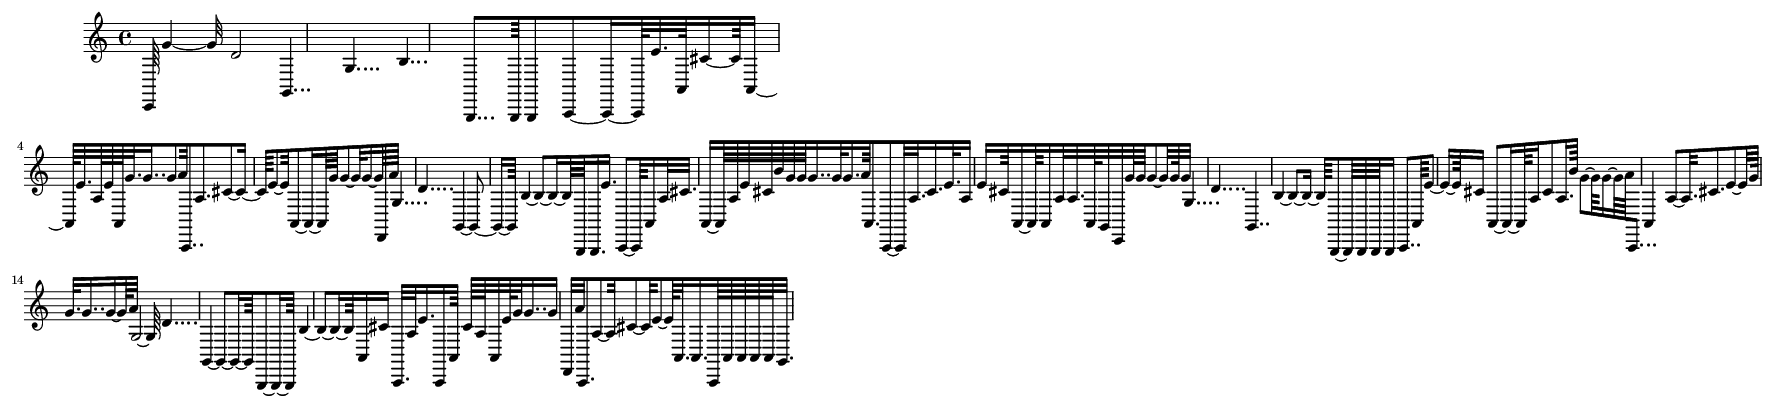

In [ ]:
show_sheet(y_midi)

Playing our generation

In [ ]:
!apt-get install fluidsynth > /dev/null
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2
!fluidsynth --version

def play_sheet(music):
  filename = music.write('mid')
  !fluidsynth -ni font.sf2 $filename -F $filename\.wav -r 16000 > /dev/null
  display(Audio(filename + '.wav'))

FluidSynth version 1.1.9
Copyright (C) 2000-2018 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

FluidSynth 1.1.9


In [ ]:
play_sheet(y_midi)